# Transfer learning with tensorflow Part 3: Scaling UP

We have seen the power of transfer learning. How we extract features from the pretrained models and use it for our advanatges. We have trained and fine tune Efficient NetB0 on 1% 10% and 100% of 10 classes.

Now it is the time to scale up the model.
We are using 101 classes of food images from the imagenet dataset. And Make a big dog model. We will trained the 101 classes of images with 10% of images of each class(by leveraging the power of transfer learning).
Our baseline to beat the 50.76% accuracy across 101 classes.


In [2]:
#Check to see if we are using GPU or not.
!nvidia-smi

Tue Jul 30 10:53:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             51W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1. Become one with the data

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-07-30 10:53:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 142.250.98.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: '101_food_classes_10_percent.zip.1'

101_food_classes_10 100%[===================>]   1.51G   249MB/s    in 6.5s    

2024-07-30 10:53:56 (238 MB/s) - '101_food_classes_10_percent.zip.1' saved [1625420029/1625420029]



In [4]:
## Creating helper function
!wget https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py

#Import the helper function
from helper_func import unzip_data,create_tensorboard_callback,walk_through_dir,plot_loss_curves,compare_historys,create_data_aug

--2024-07-30 10:53:57--  https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13288 (13K) [text/plain]
Saving to: 'helper_func.py.1'

helper_func.py.1    100%[===================>]  12.98K  --.-KB/s    in 0s      

2024-07-30 10:53:58 (70.9 MB/s) - 'helper_func.py.1' saved [13288/13288]



2024-07-30 10:53:58.592704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 10:53:58.592772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 10:53:58.594691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
unzip_data('101_food_classes_10_percent.zip')

In [6]:
#Global Variables
IMG_SIZE=(224,224)
BATCH_SIZE=32
EPOCHS=5

#Directory path
train_dir_all_data='101_food_classes_10_percent/train/'
test_dir_all_data='101_food_classes_10_percent/test/'

#image dataset directory
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data_all_10_percent=image_dataset_from_directory(train_dir_all_data,
                                                       label_mode='categorical',
                                                       image_size=IMG_SIZE,
                                                      shuffle=False)
test_data_all_10_percent=image_dataset_from_directory(test_dir_all_data,
                                                      label_mode='categorical',
                                                      image_size=(224,224))

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
#How many classes?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75

## Train the BIG_DOG_MODEL with transfer learning 10% of food 101 food classes.
Here are the steps we're goign to use:
* Create a ModelCheckpoint CallBack
* Create a Data Augmentation layer to build the augmentation layer right into the model.
* Build headless (No top layer ) functional EfficientNetB0 backboned model(we'll create our own output layer)
* Compile the model
* Feature Extraction for 5 full classes (5 Epochs on train dataset and validate on 15% of the data to save the epoch time.)

In [8]:
#Create a modelCheckpoint callback
checkpoint_path='101_classes_10_percent_data_model_checkpoints/checkpoint.weights.h5'

def model_checkpoint_callback(checkpoint_path):
  """
  Function to create a model checkpoint callback
  Here it will be used to load the weights of a trained model for fine tunning.
  """
  modelcheckpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                              save_weights_only=True,
                                                              save_best_only=True,
                                                              save_freq='epoch',
                                                              verbose=1)
  return modelcheckpoint_callback

In [9]:
#Import tensorflow
import tensorflow as tf

#Create a data augmentation layer
from tensorflow.keras.layers import RandomFlip,RandomRotation,RandomZoom,RandomWidth,RandomHeight,Rescaling

data_aug=tf.keras.models.Sequential([
    RandomFlip('horizontal'),
    RandomZoom(0.2),
    RandomRotation(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2), #Efficient net models has inbuild rescaling
    #Rescaling(1/255) #Required in models like ResNet50
],name='Data_Augmentation_Layer')

In [10]:
# Setup the base_model and freeze the layers (this will extract features)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create the model

# 1. Create a Input layer
input_layer=tf.keras.layers.Input(shape=IMG_SIZE+(3,),
                                  name='Input_layer')
x=data_aug(input_layer)
x=base_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
output_layer=tf.keras.layers.Dense(101,activation='softmax')(x)

model=tf.keras.models.Model(input_layer,output_layer)

In [11]:
#Get the summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation_Layer         │ (None, None, None, 3)  │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
#Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#Fit the model
history_all_classes_10_percent=model.fit(test_data_all_10_percent,
          epochs=EPOCHS,
          steps_per_epoch=len(test_data_all_10_percent),
          validation_data=train_data_all_10_percent,
          validation_steps=int(0.25*len(train_data_all_10_percent)),
          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                 experiment_name='all_classes_10_percent_feature_extraction'),model_checkpoint_callback(checkpoint_path)])

Saving TensorBoard log files to: transfer_learning/all_classes_10_percent_feature_extraction/20240730-105442
Epoch 1/5


2024-07-30 10:54:53.071356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2766 - loss: 3.2839
Epoch 1: val_loss improved from inf to 2.22934, saving model to 101_classes_10_percent_data_model_checkpoints/checkpoint.weights.h5
790/790 ━━━━━━━━━━━━━━━━━━━━ 98s 107ms/step - accuracy: 0.2769 - loss: 3.2823 - val_accuracy: 0.4380 - val_loss: 2.2293
Epoch 2/5


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 2.22934 to 2.08016, saving model to 101_classes_10_percent_data_model_checkpoints/checkpoint.weights.h5
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4979 - val_loss: 2.0802
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5212 - loss: 1.9268
Epoch 3: val_loss improved from 2.08016 to 1.63400, saving model to 101_classes_10_percent_data_model_checkpoints/checkpoint.weights.h5
790/790 ━━━━━━━━━━━━━━━━━━━━ 79s 100ms/step - accuracy: 0.5213 - loss: 1.9267 - val_accuracy: 0.5916 - val_loss: 1.6340
Epoch 4/5

Epoch 4: val_loss did not improve from 1.63400
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5180 - val_loss: 1.8687
Epoch 5/5
789/790 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5678 - loss: 1.6842
Epoch 5: val_loss did not improve from 1.63400
790/790 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.5678 - loss: 1.6842 - v

In [13]:
# Evaluate the model
fine_tunning_result=model.evaluate(train_data_all_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.5341 - loss: 1.8393


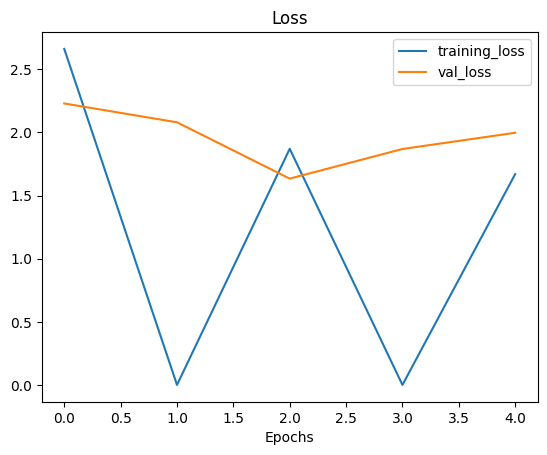

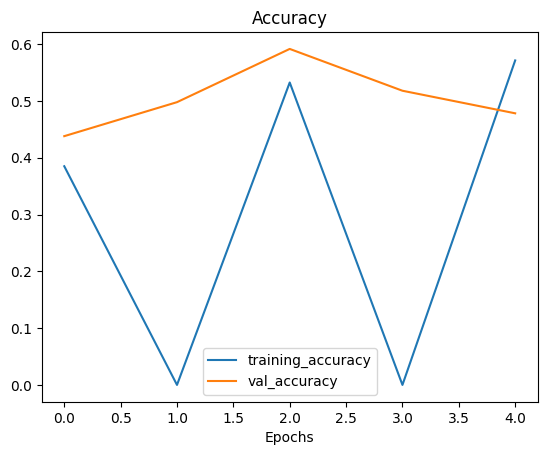

In [14]:
plot_loss_curves(history_all_classes_10_percent)

### Fine Tunning

In [15]:
#Unfreeze the layers
base_model.trainable=True

#Refreeze the layers except last 5
for i in base_model.layers[:-5]:
  i.trainable=False

#Checking for the layer which are freeze
for layer_number,layer in enumerate(base_model.layers):
  if layer.trainable==True:
    print(f"Layer{layer_number} {layer.name},{layer.trainable}")

Layer233 block7a_project_conv,True
Layer234 block7a_project_bn,True
Layer235 top_conv,True
Layer236 top_bn,True
Layer237 top_activation,True


In [16]:
#Recompile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [17]:
#Fine-tune for more 5 Epochs
initial_epochs=5
fine_tune_epochs=10+initial_epochs

#Fine-tune the model
history_all_classes_10_percent_fine_tune=model.fit(test_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   initial_epoch=initial_epochs,
                                                   steps_per_epoch=len(test_data_all_10_percent),
                                                   validation_data=train_data_all_10_percent,
                                                   validation_steps=int(0.25*len(train_data_all_10_percent)),
                                                   callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                          experiment_name='all_classes_10_percent_fine_tune_last_5')])

Saving TensorBoard log files to: transfer_learning/all_classes_10_percent_fine_tune_last_5/20240730-105912
Epoch 6/15


2024-07-30 10:59:23.815881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


790/790 ━━━━━━━━━━━━━━━━━━━━ 88s 95ms/step - accuracy: 0.5815 - loss: 1.6280 - val_accuracy: 0.5508 - val_loss: 1.7743
Epoch 7/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5826 - val_loss: 1.7374
Epoch 8/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.6314 - loss: 1.4267 - val_accuracy: 0.6388 - val_loss: 1.4585
Epoch 9/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5683 - val_loss: 1.6951
Epoch 10/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.6503 - loss: 1.3360 - val_accuracy: 0.4348 - val_loss: 2.1665
Epoch 11/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5704 - val_loss: 1.6826
Epoch 12/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.6656 - loss: 1.2655 - val_accuracy: 0.6049 - val_loss: 1.6115
Epoch 13/15
790/790 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0000e+00 - lo

In [18]:
#Evaluate the whole test dataset
fine_tune_all_classes_results=model.evaluate(train_data_all_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6068 - loss: 1.5735


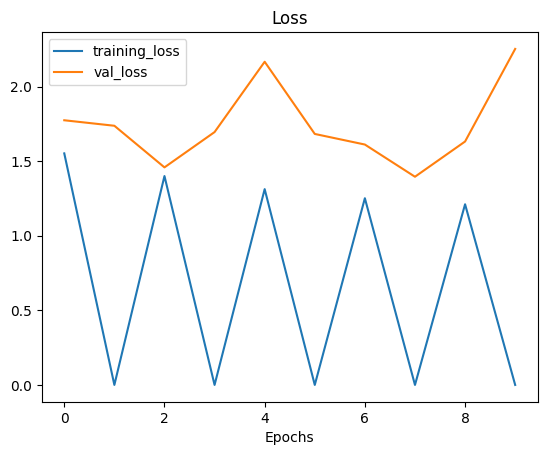

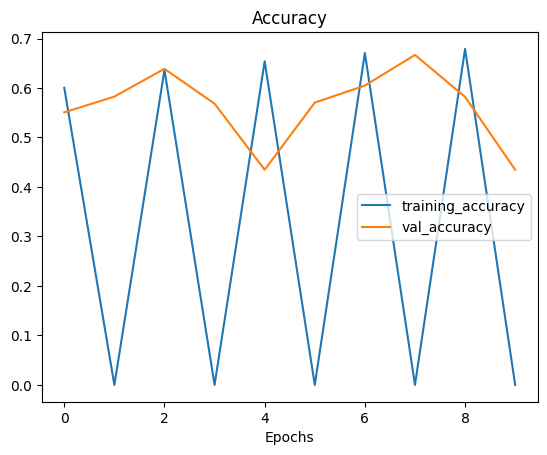

In [19]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

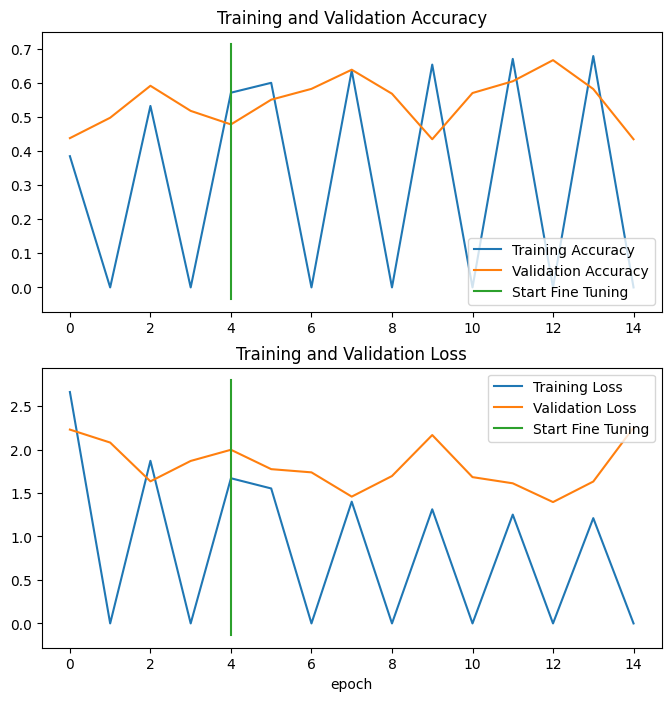

In [20]:
#Compare Historys
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [21]:
### Save and load our model

#Save model
#model.save('drive/MyDrive/tensorflow_cousre/101_classes_10_percent_data_model')
model.save('101_classes_10_percent_data.keras')
#Load the model
loaded_model=tf.keras.models.load_model('101_classes_10_percent_data.keras')

In [22]:
#Evaluate the model and compare the predictions to pre-saved model
loaded_model_results=loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - accuracy: 0.7166 - loss: 1.0364


[1.0151759386062622, 0.7209504842758179]

In [24]:
fine_tune_all_classes_results

[1.5574159622192383, 0.6128053069114685]

### Evaluating perfromance of the big dog model
Lets make predictions visualisations them and then lateer find out which predictions where the most wrong ones.

In [25]:
#import tensorflow as tf

#model=tf.keras.models.load_model("/kaggle/input/101_big_dog_model/keras/default/1/101_classes_10_percent_data.keras")
#model.summary()

In [37]:
pred_prob=loaded_model.predict(train_data_all_10_percent)

237/237 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step


In [38]:
len(train_data_all_10_percent)

237

In [39]:
#How many predictions samples are there?
len(pred_prob)

7575

In [40]:
#Lets see what first 10 predictions look like
pred_prob[:10]

array([[2.80478224e-02, 3.83131974e-03, 8.32529739e-04, ...,
        3.49752349e-03, 2.57594837e-03, 1.22726532e-02],
       [6.81250334e-01, 3.90739297e-04, 2.84542842e-03, ...,
        3.40850162e-03, 4.99960515e-05, 1.53294997e-02],
       [8.31820369e-02, 1.75952955e-05, 1.08042157e-04, ...,
        6.64090214e-04, 3.59996448e-05, 1.50759320e-03],
       ...,
       [1.87890142e-01, 2.26396206e-03, 2.79809684e-01, ...,
        2.23597046e-03, 8.37980842e-05, 3.08545335e-04],
       [2.93188244e-01, 7.28048981e-05, 4.65105148e-03, ...,
        6.93771243e-02, 8.44852038e-05, 6.67173881e-03],
       [5.03848959e-03, 5.72362369e-05, 1.05906736e-04, ...,
        2.38364507e-02, 6.30038907e-04, 1.15455156e-02]], dtype=float32)

In [41]:
#What does first preditions probability looks like?
pred_prob[0],len(pred_prob[0]),sum(pred_prob[0])

(array([2.80478224e-02, 3.83131974e-03, 8.32529739e-04, 1.46238628e-04,
        1.15481000e-02, 5.43693500e-03, 1.05704926e-03, 5.57363406e-02,
        1.56254828e-01, 8.30609002e-04, 1.19338220e-05, 2.29077032e-05,
        4.12595109e-05, 6.01602151e-05, 2.65035233e-05, 4.42722486e-03,
        2.95116869e-03, 5.69200655e-03, 9.44784563e-03, 2.85534770e-05,
        3.82163358e-04, 4.11006482e-03, 3.21943760e-02, 6.40242966e-03,
        1.90934497e-05, 2.81599532e-05, 6.75044939e-05, 6.30924711e-03,
        2.54834977e-05, 4.99970338e-04, 2.90835247e-04, 1.66743412e-03,
        2.09704740e-03, 1.19068916e-03, 8.04312469e-04, 1.16312574e-03,
        1.48345092e-02, 1.65629853e-02, 2.15969374e-03, 1.23422481e-02,
        1.57609824e-02, 8.75009969e-03, 1.09781511e-02, 4.71572839e-02,
        3.38526152e-05, 1.54146005e-03, 2.05122866e-04, 1.32478322e-04,
        5.49774122e-05, 8.05564516e-04, 7.69597071e-04, 7.58556835e-03,
        1.70830414e-02, 1.81221962e-01, 1.78546834e-05, 9.906251

Our model predicst the probabilities of all classes we have to take out max value out of all prob. And gives its index|

In [42]:
#We get one preidictions probability per class(in our class there's 101 predictions probabilities)
print(f"Number of Probabilities for one Sample:{len(pred_prob[0])}")
print(f"What are the predictions probabilities of the first samples:{pred_prob[0]}")
print(f"The Class with highest predicted probability by the model 0:{pred_prob[0].argmax()}")

Number of Probabilities for one Sample:101
What are the predictions probabilities of the first samples:[2.80478224e-02 3.83131974e-03 8.32529739e-04 1.46238628e-04
 1.15481000e-02 5.43693500e-03 1.05704926e-03 5.57363406e-02
 1.56254828e-01 8.30609002e-04 1.19338220e-05 2.29077032e-05
 4.12595109e-05 6.01602151e-05 2.65035233e-05 4.42722486e-03
 2.95116869e-03 5.69200655e-03 9.44784563e-03 2.85534770e-05
 3.82163358e-04 4.11006482e-03 3.21943760e-02 6.40242966e-03
 1.90934497e-05 2.81599532e-05 6.75044939e-05 6.30924711e-03
 2.54834977e-05 4.99970338e-04 2.90835247e-04 1.66743412e-03
 2.09704740e-03 1.19068916e-03 8.04312469e-04 1.16312574e-03
 1.48345092e-02 1.65629853e-02 2.15969374e-03 1.23422481e-02
 1.57609824e-02 8.75009969e-03 1.09781511e-02 4.71572839e-02
 3.38526152e-05 1.54146005e-03 2.05122866e-04 1.32478322e-04
 5.49774122e-05 8.05564516e-04 7.69597071e-04 7.58556835e-03
 1.70830414e-02 1.81221962e-01 1.78546834e-05 9.90625122e-04
 1.26626985e-02 3.07283015e-03 2.22004112e-

In [43]:
#Get predictions classes of each label
pred_classes=pred_prob.argmax(axis=1)

#How do they look?
pred_classes[:10]

array([53,  0, 76, 54, 99,  8,  0,  2,  0,  8])

In [44]:
#How many pred classes do we have?
len(pred_classes)

7575

Now we;ve got predictions array of all our models predictions to evaluate them,we need to comapre thme to the original test dataset labels.

In [45]:
train_data_all_10_percent

#TO get our test label we need to unravel our test_data BatchDataset
y_labels=[]
for images,labels in train_data_all_10_percent.unbatch():
    y_labels.append(labels.numpy().argmax())
    
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [46]:
#How many y_labels?
len(y_labels)

7575

## Evaluate the models predictions 
One way to check the performance array is the same order as our test labels array array is to find the accuracy score.

In [47]:
#Lets try scikit learn accuracy score for function see what happesn
from sklearn.metrics import accuracy_score

sklearn_accuracy=accuracy_score(y_true=y_labels,
                               y_pred=pred_classes)
sklearn_accuracy

0.5984158415841584

### Lets Get Visualise: Making Confusion Matrix

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

#Create a Confusion matrix
from sklearn.metrics import confusion_matrix

confu_mat=confusion_matrix(y_labels,pred_classes)

In [49]:
#Get a list of class_names
class_names=train_data_all_10_percent.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_confusion_matrix(y_true,
                         y_pred,
                         class_names,
                         fig_size=(10,10),
                         save_fig=False):
    """
    Make A Confusion matrix between predicted and true labels
    It can be used for any classification problem.
    It is used a evaluation matrix which tells about our model classify the data well.
    It contains 4 parameters:TP,FP,TN,FN
    """
    result_confusion=confusion_matrix(y_true=y_true,
                                     y_pred=y_pred)
    plt.figure(figsize=(fig_size))
    sns.heatmap(result_confusion,
               cmap='Blues',
               annot=True,
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel("Predicted Classes")
    plt.ylabel("Actual Classes")
    plt.show()
    
    #Save the figure of the class 
    if save_fig==True:
        plt.savefig("confusion_matrix.png")

In [51]:
make_confusion_matrix(y_true=y_labels,
                     y_pred=pred_classes,
                     class_names=class_names,
                     fig_size=(101,101),
                     save_fig=False)

### Lets Keep evaluation train going,time for classification for a classification report

Scikitlearn has helpfull functions for acquiring many different classification metrics like accuracy score and precision recall and f1-score.
For Above we will take f1-score as it is the harmonic mean of precision and recall.


In [52]:
from sklearn.metrics import classification_report
report=classification_report(y_true=y_labels,
                            y_pred=pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.38      0.24      0.30        75
           1       0.50      0.72      0.59        75
           2       0.81      0.61      0.70        75
           3       0.80      0.59      0.68        75
           4       0.66      0.55      0.60        75
           5       0.45      0.55      0.49        75
           6       0.90      0.76      0.83        75
           7       0.71      0.81      0.76        75
           8       0.34      0.60      0.43        75
           9       0.48      0.59      0.53        75
          10       0.47      0.48      0.47        75
          11       0.71      0.60      0.65        75
          12       0.82      0.65      0.73        75
          13       0.49      0.68      0.57        75
          14       0.51      0.52      0.51        75
          15       0.54      0.27      0.36        75
          16       0.74      0.60      0.66        75
          17       0.48    

The numbers has given big gist a great class-by-class evaluation of our models predictions but with so many classes , they'll quite understand.

How about we create a visualisation to get better understand?

In [53]:
#Get adictionary of classification_report
classification_dict=classification_report(y_true=y_labels,
                                         y_pred=pred_classes,
                                         output_dict=True)
classification_dict

{'0': {'precision': 0.3829787234042553,
  'recall': 0.24,
  'f1-score': 0.29508196721311475,
  'support': 75},
 '1': {'precision': 0.5046728971962616,
  'recall': 0.72,
  'f1-score': 0.5934065934065933,
  'support': 75},
 '2': {'precision': 0.8070175438596491,
  'recall': 0.6133333333333333,
  'f1-score': 0.696969696969697,
  'support': 75},
 '3': {'precision': 0.8,
  'recall': 0.5866666666666667,
  'f1-score': 0.676923076923077,
  'support': 75},
 '4': {'precision': 0.6612903225806451,
  'recall': 0.5466666666666666,
  'f1-score': 0.5985401459854014,
  'support': 75},
 '5': {'precision': 0.45054945054945056,
  'recall': 0.5466666666666666,
  'f1-score': 0.4939759036144578,
  'support': 75},
 '6': {'precision': 0.9047619047619048,
  'recall': 0.76,
  'f1-score': 0.8260869565217391,
  'support': 75},
 '7': {'precision': 0.7093023255813954,
  'recall': 0.8133333333333334,
  'f1-score': 0.7577639751552795,
  'support': 75},
 '8': {'precision': 0.3409090909090909,
  'recall': 0.6,
  'f1-sc

Lets a plot all our f1_scores

In [54]:
class_names[98]

'tiramisu'

In [55]:
classification_dict['98']

{'precision': 0.5,
 'recall': 0.5066666666666667,
 'f1-score': 0.5033112582781457,
 'support': 75}

In [56]:
#Create empty dict
class_f1_scores={}

#Loop through classification report items
for k,v in classification_dict.items():
    if k=='accuracy':
        break
    else:
        #Add class_names and f1_score to new dict
        class_f1_scores[class_names[int(k)]]=v['f1-score']
class_f1_scores

{'apple_pie': 0.29508196721311475,
 'baby_back_ribs': 0.5934065934065933,
 'baklava': 0.696969696969697,
 'beef_carpaccio': 0.676923076923077,
 'beef_tartare': 0.5985401459854014,
 'beet_salad': 0.4939759036144578,
 'beignets': 0.8260869565217391,
 'bibimbap': 0.7577639751552795,
 'bread_pudding': 0.43478260869565216,
 'breakfast_burrito': 0.5269461077844311,
 'bruschetta': 0.4736842105263158,
 'caesar_salad': 0.6521739130434783,
 'cannoli': 0.725925925925926,
 'caprese_salad': 0.5698324022346369,
 'carrot_cake': 0.513157894736842,
 'ceviche': 0.35714285714285715,
 'cheese_plate': 0.6617647058823529,
 'cheesecake': 0.4729729729729729,
 'chicken_curry': 0.4999999999999999,
 'chicken_quesadilla': 0.6068965517241379,
 'chicken_wings': 0.627027027027027,
 'chocolate_cake': 0.5889570552147239,
 'chocolate_mousse': 0.42038216560509556,
 'churros': 0.7428571428571429,
 'clam_chowder': 0.7552447552447551,
 'club_sandwich': 0.6299212598425197,
 'crab_cakes': 0.41935483870967744,
 'creme_brulee'

In [59]:
#Turn f1_scores into visualisation 
import pandas as pd
f1_scores=pd.DataFrame({'class_names':list(class_f1_scores.keys()),
                       'f1-score':list(class_f1_scores.values())}).sort_values(by='f1-score',ascending=False)

In [60]:
f1_scores[:10]

,class_names,f1-score
33,edamame,0.925000
64,miso_soup,0.868421
63,macarons,0.852941
54,hot_and_sour_soup,0.844156
91,spaghetti_carbonara,0.838235
68,onion_rings,0.830189
6,beignets,0.826087
75,pho,0.825000
51,guacamole,0.819876
90,spaghetti_bolognese,0.810811


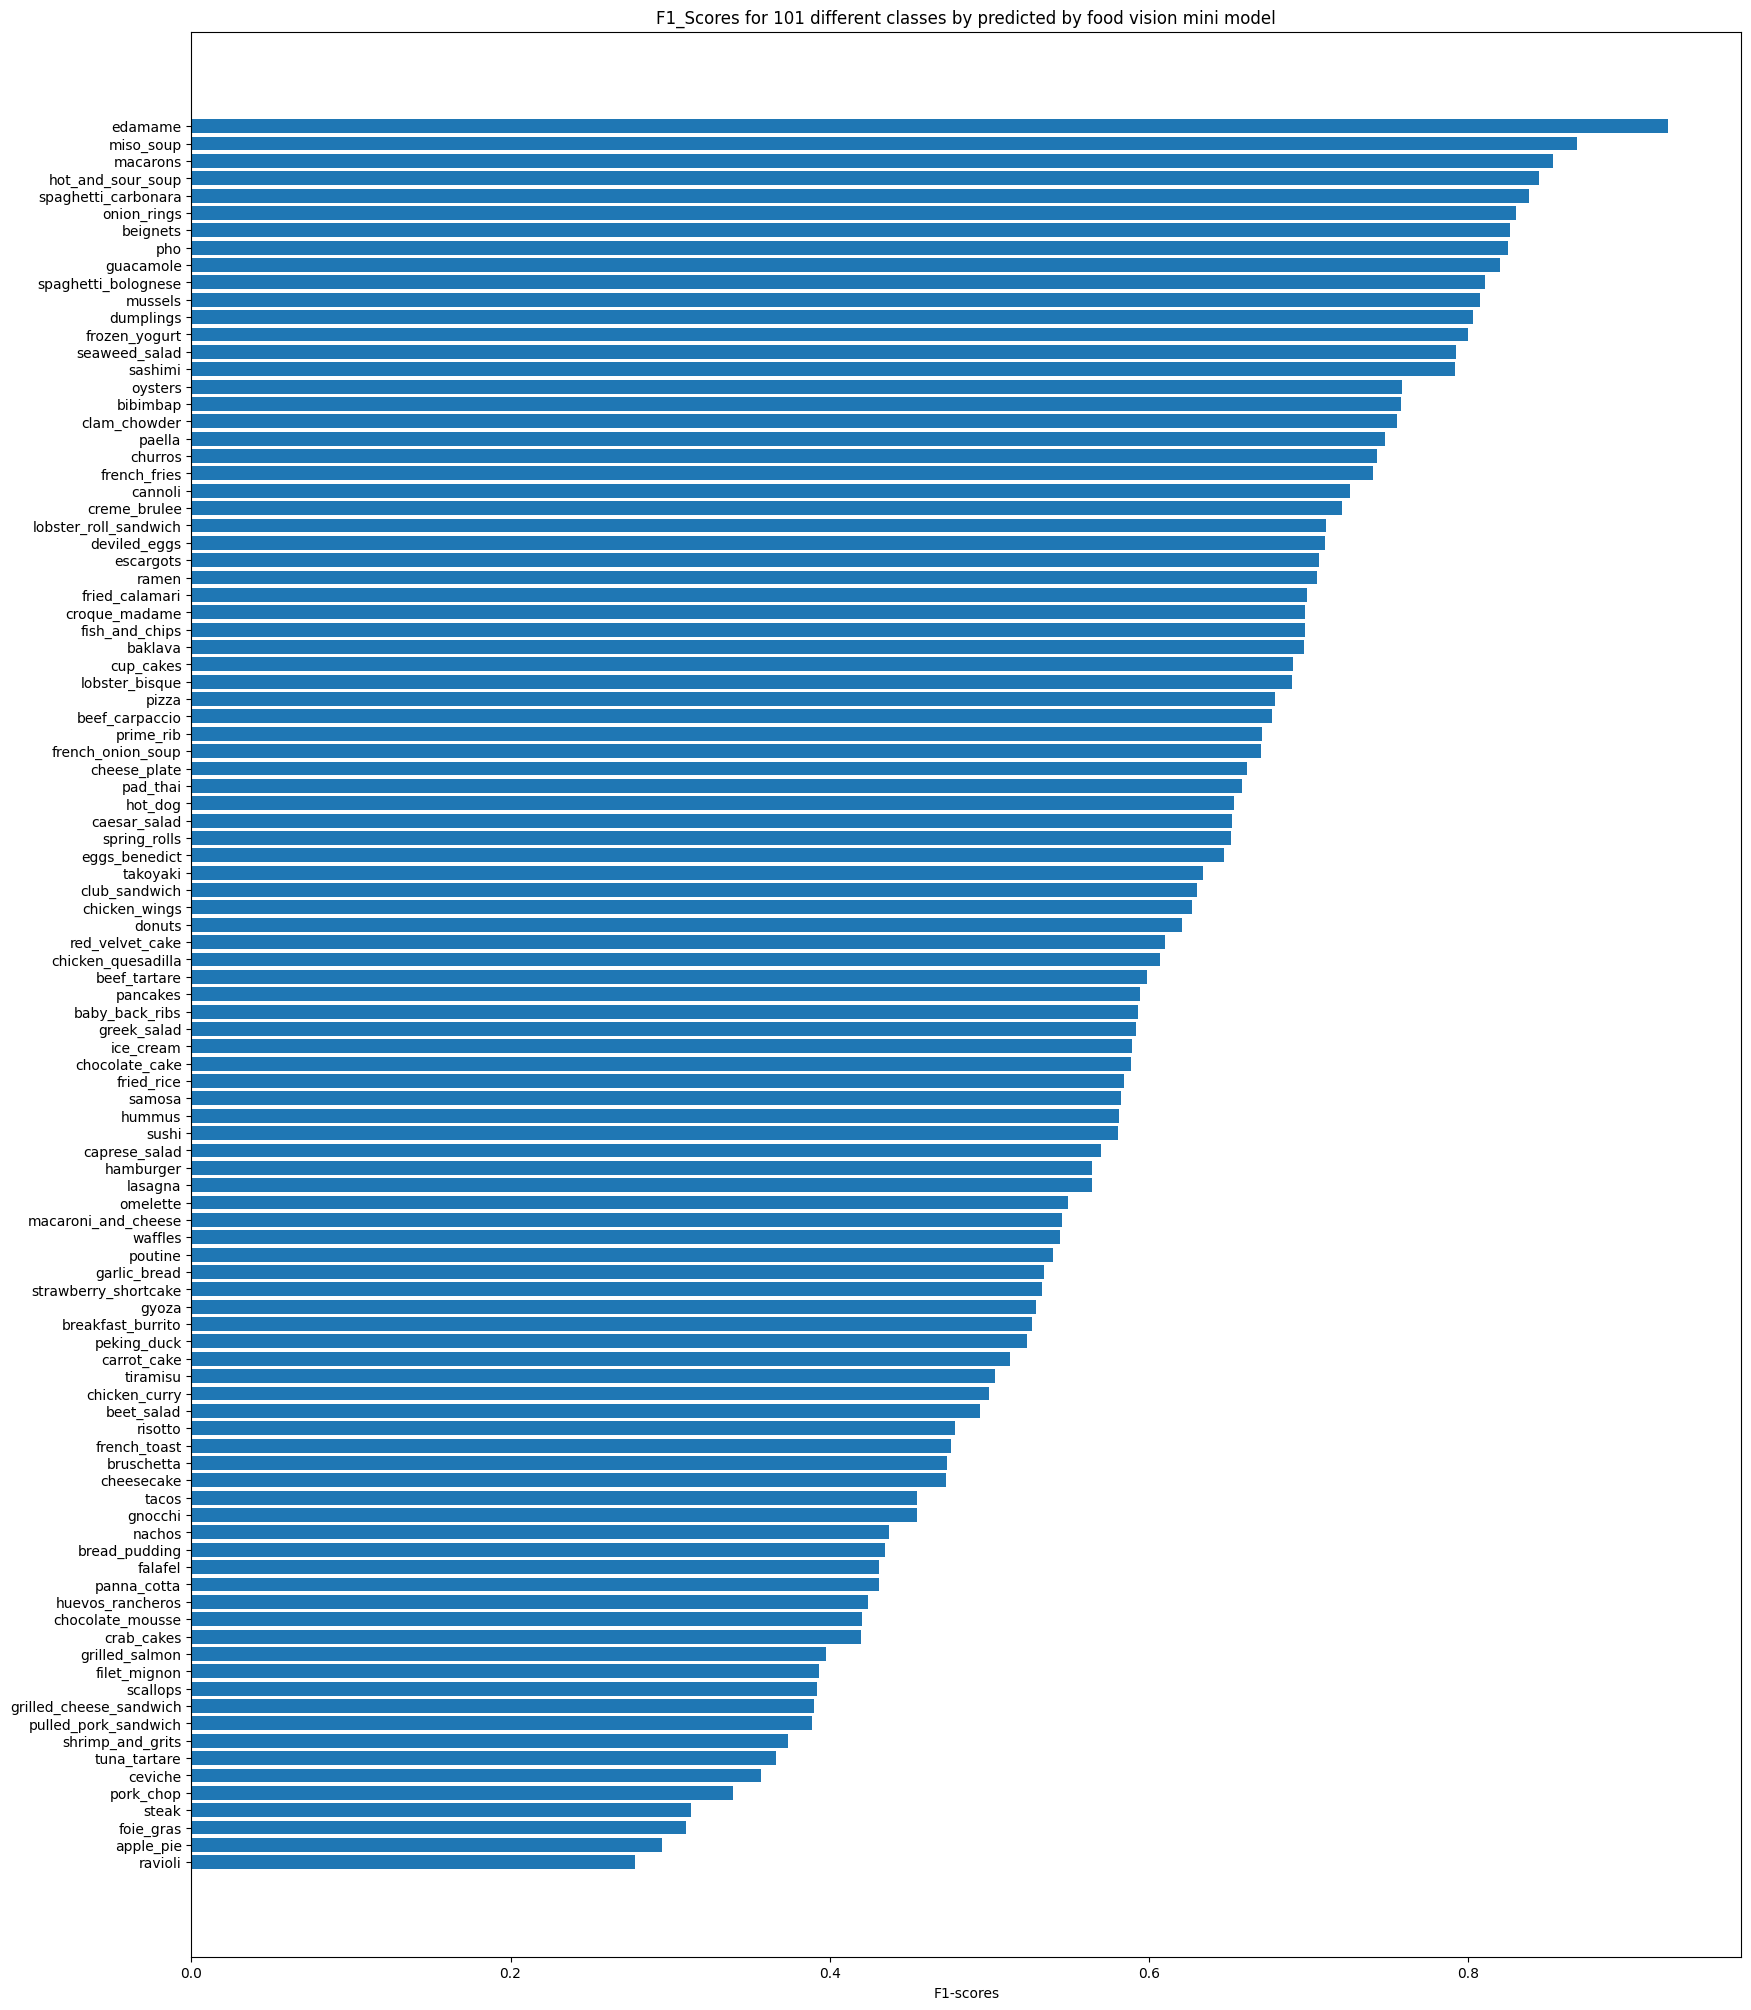

In [61]:
import matplotlib.pyplot as plt

#Plot the scores
fig,ax=plt.subplots(figsize=(20,25))
scores=ax.barh(range(len(f1_scores)),f1_scores['f1-score'].values) #Get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-scores')
ax.set_title('F1_Scores for 101 different classes by predicted by food vision mini model')
ax.invert_yaxis(); #Reverse the order of our plot

### Visualising predictions on test images here
Now this is the real test how does our model go on food images not even in our test dataset(images of our own).

TO visualise the models predictions on our images we;need a functions to load_and_preproces images:
1. Read the target image filepath using tf.io.read_file()
2. Trun the images into tensors using tf.io.decode_file()
3. Resize the images of tensors to be used as the images our model has trained on using tf.image.resize()
4. Scale the images to get all of the pixel values between 0 and 1.

In [62]:
#Create a function to load and preprocess images
def load_and_preprocess_image(filename,img_shape=224,scale=True):
    """
    Read in an image sfile and turns it into a tensor
    specified image (img_shape,img_shape,3) 3 is for color channels
    returns:
        Image Tensor of shape (img_shape,img_shape,3)
    """
    #Read in the target image
    img=tf.io.read_file(filename)
    
    #Decode image into tensor
    img=tf.io.decode_image(img,channels=3)
    
    #Resize the image
    img=tf.image.resize(img,[img_shape,img_shape])
    
    #Scale 
    if scale:
        #Rescale the images between 0 and 1
        return img/255
    else:
        return img

Now lets write some code to visualise the images,lets now write some code to visualise images,thier target labels and our models predictions.

Specifically, we;ll some code to:
   1. Load a few random images from the test dataset
   2. Make a predictions on loaded images
   3. Plot the original images along with the model predictions,predictions probability and true label

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: french_onion_soup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: french_onion_soup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: french_onion_soup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: french_onion_soup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: french_onion_soup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: french_onion_soup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: french_onion_soup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: french_onion_soup
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: french_onion_soup


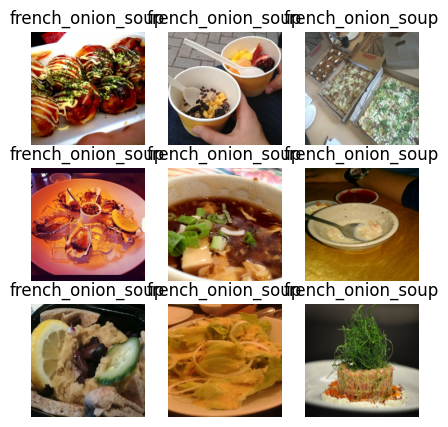

In [63]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Assuming class_names is a list of class names and train_dir_all_data is the directory with training data
# Also assuming model is already loaded and available

def load_and_preprocess_image(file_path):
    # Load and preprocess the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [224, 224]) # Adjust size if needed
    img = img / 255.0  # Normalize to [0, 1] if needed
    return img

plt.figure(figsize=(5,5))
for i in range(9):
    # Choose a random image from random_image
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(os.path.join(train_dir_all_data, class_name)))
    file_path = os.path.join(train_dir_all_data, class_name, filename)
    #print(f"File path: {file_path}")
    
    # Load and preprocess the image
    img = load_and_preprocess_image(file_path)
    #print(f"Image shape: {img.shape}")
    
    # Get prediction probability
    preds_prob = model.predict(tf.expand_dims(img, axis=0))
    #print(f"Prediction probabilities: {preds_prob}")
    
    # Get the predicted class
    predicted_class = class_names[preds_prob.argmax()]
    print(f"Predicted class: {predicted_class}")

    # Plotting the image with the predicted class
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(predicted_class)
    plt.axis('off')

plt.show()
